# Montogomery Projected coordinates
## Real world examples measuring over all the levels of security

In [1]:
from hwcounter import Timer, count, count_end
import time
import collections

In [2]:
import import_ipynb

In [3]:
from FP2 import *

importing Jupyter notebook from FP2.ipynb


In [4]:
import numpy as np

### - To define a Montogomery elliptic curve using affine coordinates, we simply use the equation:  $B.y^2 = x^3+Ax^2+x$ and according to that each point can be represented using the Affine normalized coordinates with (x,y,1) (i.e. z value always =1).

### - Another way to represent an elliptic curve is using the  projected coordinates. In the projective form, a point represented using the affine normalized form as (x,y,1) can be mapped to a point  (X, Y, Z) and the mapping is defined  as follows: $(x,y,1) \rightarrow (xZ: yZ: Z)$ with Z$\neq 0$, while  the reverse map is: $(X: Y: Z) \rightarrow (X/Z: Y/Z:1)$, the value of Z  always $\neq 0$ except for  the point of infinity which is having $Z=0.$ i.e. $ O = (0:1:0)$

### - As we can observe, the same point $(x,y,1)$ can have different representations in the projective form depending on the value of Z ; therefore, we can write: $(x,y,1) \sim (X,Y,Z) \sim (X^\prime, Y^\prime,Z^\prime)$ where $X =Zx, Y = Zy, X^\prime = rX, Y^\prime= rY , Z^\prime = rZ $

### - As it was shown earlier, by defining the elliptic curve using the normalized affine coordinates, we observe that the scalar multiplication $P \rightarrow [n]P :(x_P,y_P) \rightarrow (x_{[nP]}, y_{[nP]})$ with $x_{[nP]}$ is a function of $x_P$ only.

### - Similarly, by computing the isogeny maps of degree n, $ \phi_n: E_{A,B} \rightarrow E_{A^\prime, B^\prime}$ with $P (x_P, y_P) \in E_{A,B} \rightarrow \phi_n(P) =(\phi_n(x_P), \phi_n(y_P)) \in E_{A^\prime, B^\prime}$ , we can see  that $\phi_n(x_P)$ is a function of $x_P$ only.

### - Based on that, an optimized implementation for scalar multiplication and isogeny maps calculations can be built by considering only the x-coordinate and ignoring y-coordinate.

### - Hence, in the projective form, each point is represented as (X: Z) only except the point of infinity which is represented as (1:0)

### - Based on the new representation an optimized inversion-free implementation can be define for scalar multiplications as well as computing the isogeny maps (see <a href="https://eprint.iacr.org/2017/212.pdf">Montgomery curves and their arithmetic</a>).
### - The intution behind the inversion-free implementation is  to avoid doing many division operations and defer them till the end to convert from the projective coordinates to the affine normalized coordinates. 


## Define the needed functions

In [5]:
def get_basis_points(level):
    # input : -  E the initial elliptic curve E
    #         - The level of securrity matching SIKE434, SIKE503, SIKE610, SIKE751 respectively
    # output: - PA, QA, RA: Alice's points on E with order of 2^{e_A} where RA = PA-QA
    #         - PB, QB, RB: Bob's points on E with order of 3^{e_B}, where RB = PB-QB
    if(level == 0): ##SIKEp434 basis points##
        xQ20 = 0x0000C7461738340EFCF09CE388F666EB38F7F3AFD42DC0B664D9F461F31AA2EDC6B4AB71BD42F4D7C058E13F64B237EF7DDD2ABC0DEB0C6C
        xQ21 = 0x000025DE37157F50D75D320DD0682AB4A67E471586FBC2D31AA32E6957FA2B2614C4CD40A1E27283EAAF4272AE517847197432E2D61C85F5
        
        xP20 = 0x00003CCFC5E1F050030363E6920A0F7A4C6C71E63DE63A0E6475AF621995705F7C84500CB2BB61E950E19EAB8661D25C4A50ED279646CB48
        xP21 = 0x0001AD1C1CAE7840EDDA6D8A924520F60E573D3B9DFAC6D189941CB22326D284A8816CC4249410FE80D68047D823C97D705246F869E3EA50
       
        xR20 = 0x0000F37AB34BA0CEAD94F43CDC50DE06AD19C67CE4928346E829CB92580DA84D7C36506A2516696BBE3AEB523AD7172A6D239513C5FD2516
        xR21 = 0x000196CA2ED06A657E90A73543F3902C208F410895B49CF84CD89BE9ED6E4EE7E8DF90B05F3FDB8BDFE489D1B3558E987013F9806036C5AC
        
        
        QA = (xQ21*i + xQ20, 1+0*i)
        PA = (xP21*i + xP20, 1+0*i)
        RA = (xR21*i + xR20, 1+0*i)
        
        xQ30 = 0x00012E84D7652558E694BF84C1FBDAAF99B83B4266C32EC65B10457BCAF94C63EB063681E8B1E7398C0B241C19B9665FDB9E1406DA3D3846
        xQ31 = 0x00000000
        
        xP30 = 0x00008664865EA7D816F03B31E223C26D406A2C6CD0C3D667466056AAE85895EC37368BFC009DFAFCB3D97E639F65E9E45F46573B0637B7A9
        xP31 = 0x00000000
        
        xR30 = 0x0001CD28597256D4FFE7E002E87870752A8F8A64A1CC78B5A2122074783F51B4FDE90E89C48ED91A8F4A0CCBACBFA7F51A89CE518A52B76C
        xR31 = 0x000147073290D78DD0CC8420B1188187D1A49DBFA24F26AAD46B2D9BB547DBB6F63A760ECB0C2B20BE52FB77BD2776C3D14BCBC404736AE4
        
        QB = (xQ31*i+xQ30,1+0*i)
        PB = (xP31*i+xP30,1+0*i)
        RB = (xR31*i+xR30,1+0*i)
        
    elif(level == 1): ##SIKEp503 basis points###
        xQ20 = 0x00325CF6A8E2C6183A8B9932198039A7F965BA8587B67925D08D809DBF9A69DE1B621F7F134FA2DAB82FF5A2615F92CC71419FFFAAF86A290D604AB167616461
        xQ21 = 0x003E7B0494C8E60A8B72308AE09ED34845B34EA0911E356B77A11872CF7FEEFF745D98D0624097BC1AD7CD2ADF7FFC2C1AA5BA3C6684B964FA555A0715E57DB1
       
        xP20 = 0x0002ED31A03825FA14BC1D92C503C061D843223E611A92D7C5FBEC0F2C915EE7EEE73374DF6A1161EA00CDCB786155E21FD38220C3772CE670BC68274B851678
        xP21 = 0x001EE4E4E9448FBBAB4B5BAEF280A99B7BF86A1CE05D55BD603C3BA9D7C08FD8DE7968B49A78851FFBC6D0A17CB2FA1B57F3BABEF87720DD9A489B5581F915D2
       
        xR20 = 0x003D24CF1F347F1DA54C1696442E6AFC192CEE5E320905E0EAB3C9D3FB595CA26C154F39427A0416A9F36337354CF1E6E5AEDD73DF80C710026D49550AC8CE9F
        xR21 = 0x0006869EA28E4CEE05DCEE8B08ACD59775D03DAA0DC8B094C85156C212C23C72CB2AB2D2D90D46375AA6D66E58E44F8F219431D3006FDED7993F51649C029498
       
        QA = (xQ21*i + xQ20,1+0*i)
        PA = (xP21*i + xP20,1+0*i)
        RA = (xR21*i + xR20,1+0*i)
        
        xQ30 = 0x0039014A74763076675D24CF3FA28318DAC75BCB04E54ADDC6494693F72EBB7DA7DC6A3BBCD188DAD5BECE9D6BB4ABDD05DB38C5FBE52D985DCAF74422C24D53
        xQ31 = 0x00000000
        
        xP30 = 0x0032D03FD1E99ED0CB05C0707AF74617CBEA5AC6B75905B4B54B1B0C2D73697840155E7B1005EFB02B5D02797A8B66A5D258C76A3C9EF745CECE11E9A178BADF
        xP31 = 0x00000000
        
        xR30 = 0x0000C1465FD048FFB8BF2158ED57F0CFFF0C4D5A4397C7542D722567700FDBB8B2825CAB4B725764F5F528294B7F95C17D560E25660AD3D07AB011D95B2CB522
        xR31 = 0x00288165466888BE1E78DB339034E2B8C7BDF0483BFA7AB943DFA05B2D1712317916690F5E713740E7C7D4838296E67357DC34E3460A95C330D5169721981758
        
        QB = (xQ31*i+xQ30,1+0*i)
        PB = (xP31*i+xP30,1+0*i)
        RB = (xR31*i+xR30,1+0*i)
        
    elif(level == 2): ##SIKEp610##
        xQ20 = 0x25DA39EC90CDFB9BC0F772CDA52CB8B5A9F478D7AF8DBBA0AEB3E52432822DD88C38F4E3AEC0746E56149F1FE89707C77F8BA4134568629724F4A8E34B06BFE5C5E66E0867EC38B283798B8A
        xQ21 = 0x00000002250E1959256AE502428338CB4715399551AEC78D8935B2DC73FCDCFBDB1A0118A2D3EF03489BA6F637B1C7FEE7E5F31340A1A537B76B5B736B4CDD284918918E8C986FC02741FB8C98F0A0ED
        
        xP20 = 0x00000001B368BC6019B46CD802129209B3E65B98BC64A92BC4DB2F9F3AC96B97A1B9C124DF549B528F18BEECB1666D27D47530435E84221272F3A97FB80527D8F8A359F8F1598D365744CA3070A5F26C
        xP21 = 0x00000001459685DCA7112D1F6030DBC98F2C9CBB41617B6AD913E6523416CCBD8ED9C7841D97DF83092B9B3F2AF00D62E08DAD8FA743CBCCCC1782BE0186A3432D3C97C37CA16873BEDE01F0637C1AA2
        
        xR20 = 0x00000001B36A006D05F9E370D5078CCA54A16845B2BFF737C865368707C0DBBE9F5A62A9B9C79ADF11932A9FA4806210E25C92DB019CC146706DFBC7FA2638ECC4343C1E390426FAA7F2F07FDA163FB5
        xR21 = 0x0000000183C9ABF2297CA69699357F58FED92553436BBEBA2C3600D89522E7009D19EA5D6C18CFF993AA3AA33923ED93592B0637ED0B33ADF12388AE912BC4AE4749E2DF3C3292994DCF37747518A992
       
        QA = (xQ21*i + xQ20,1+0*i)
        PA = (xP21*i + xP20,1+0*i)
        RA = (xR21*i + xR20,1+0*i)
    
        xQ30 = 0x000000014E647CB19B7EAAAC640A9C26B9C26DB7DEDA8FC9399F4F8CE620D2B2200480F4338755AE16D0E090F15EA1882166836A478C6E161C938E4EB8C2DD779B45FFDD17DCDF158AF48DE126B3A047
        xQ31 = 0x00000000
        
        xP30 = 0x00000001587822E647707ED4313D3BE6A811A694FB201561111838A0816BFB5DEC625D23772DE48A26D78C04EEB26CA4A571C67CE4DC4C620282876B2F2FC2633CA548C3AB0C45CC991417A56F7FEFEB
        xP31 = 0x00000000
        
        xR30 = 0x00000001DB73BC2DE666D24E59AF5E23B79251BA0D189629EF87E56C38778A448FACE312D08EDFB876C3FD45ECF3746D96E2CADBBA08B1A206C47DDD93137059E34C90E2E42E10F30F6E5F52DED74222
        xR31 = 0x00000001B2C30180DAF5D91871555CE8EFEC76A4D521F877B754311228C7180A3E2318B4E7A00341FF99F34E35BF7A1053CA76FD77C0AFAE38E2091862AB4F1DD4C8D9C83DE37ACBA6646EDB4C238B48
        
        QB = (xQ31*i+xQ30,1+0*i)
        PB = (xP31*i+xP30,1+0*i)
        RB = (xR31*i+xR30,1+0*i)
        
    elif(level == 3): ##SIKEp751##
        xQ20 = 0x00001723D2BFA01A78BF4E39E3A333F8A7E0B415A17F208D3419E7591D59D8ABDB7EE6D2B2DFCB21AC29A40F837983C0F057FD041AD93237704F1597D87F074F682961A38B5489D1019924F8A0EF5E4F1B2E64A7BA536E219F5090F76276290E
        xQ21 = 0x00002569D7EAFB6C60B244EF49E05B5E23F73C4F44169A7E02405E90CEB680CB0756054AC0E3DCE95E2950334262CC973235C2F87D89500BCD465B078BD0DEBDF322A2F86AEDFDCFEE65C09377EFBA0C5384DD837BEDB710209FBC8DDB8C35C7
       
        xP20 = 0x00004514F8CC94B140F24874F8B87281FA6004CA5B3637C68AC0C0BDB29838051F385FBBCC300BBB24BFBBF6710D7DC8B29ACB81E429BD1BD5629AD0ECAD7C90622F6BB801D0337EE6BC78A7F12FDCB09DECFAE8BFD643C89C3BAC1D87F8B6FA
        xP21 = 0x0000158ABF500B5914B3A96CED5FDB37D6DD925F2D6E4F7FEA3CC16E1085754077737EA6F8CC74938D971DA289DCF2435BCAC1897D2627693F9BB167DC01BE34AC494C60B8A0F65A28D7A31EA0D54640653A8099CE5A84E4F0168D818AF02041
        
        xR20 = 0x00006066E07F3C0D964E8BC963519FAC8397DF477AEA9A067F3BE343BC53C883AF29CCF008E5A30719A29357A8C33EB3600CD078AF1C40ED5792763A4D213EBDE44CC623195C387E0201E7231C529A15AF5AB743EE9E7C9C37AF3051167525BB
        xR21 = 0x000050E30C2C06494249BC4A144EB5F31212BD05A2AF0CB3064C322FC3604FC5F5FE3A08FB3A02B05A48557E15C992254FFC8910B72B8E1328B4893CDCFBFC003878881CE390D909E39F83C5006E0AE979587775443483D13C65B107FADA5165
      
        QA = (xQ21*i + xQ20,1+0*i)
        PA = (xP21*i + xP20,1+0*i)
        RA = (xR21*i + xR20,1+0*i)
        
        xQ30 = 0x00005BF9544781803CBD7E0EA8B96D934C5CBCA970F9CC327A0A7E4DAD931EC29BAA8A854B8A9FDE5409AF96C5426FA375D99C68E9AE714172D7F04502D45307FA4839F39A28338BBAFD54A461A535408367D5132E6AA0D3DA6973360F8CD0F1
        xQ31 = 0x00000000
       
        xP30 = 0x0000605D4697A245C394B98024A5554746DC12FF56D0C6F15D2F48123B6D9C498EEE98E8F7CD6E216E2F1FF7CE0C969CCA29CAA2FAA57174EF985AC0A504260018760E9FDF67467E20C13982FF5B49B8BEAB05F6023AF873F827400E453432FE
        xP31 = 0x00000000
        
        xR30 = 0x000055E5124A05D4809585F67FE9EA1F02A06CD411F38588BB631BF789C3F98D1C3325843BB53D9B011D8BD1F682C0E4D8A5E723364364E40DAD1B7A476716AC7D1BA705CCDD680BFD4FE4739CC21A9A59ED544B82566BF633E8950186A79FE3
        xR31 = 0x00005AC57EAFD6CC7569E8B53A148721953262C5B404C143380ADCC184B6C21F0CAFE095B7E9C79CA88791F9A72F1B2F3121829B2622515B694A16875ED637F421B539E66F2FEF1CE8DCEFC8AEA608055E9C44077266AB64611BF851BA06C821
       
        QB = (xQ31*i+xQ30,1+0*i)
        PB = (xP31*i+xP30,1+0*i)
        RB = (xR31*i+xR30,1+0*i)
    return PA, QA, RA, PB, QB, RB
    

In [6]:
def get_strategy(level):
    #This function returns the suitable strategy to calculate isogeny maps of degrees 2^{e_A}, 3^{e_B} respectively.
    #The input: - The level of securrity in the set {0,1,2,3} matching SIKE434, SIKE503, SIKE610, SIKE751 respectively
    #output: -strtagey4: This strategy for 4-isogeny calculations to do calculations in 2-torsion
    #        -strategy3: This strategy for 3-isogeny calculations to do calculations in 3-torsion
    
    strategy4 = [] ## 
    strategy3 = [] ## 
    if(level == 0):
        strategy4 =  [48, 28, 16, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 13,
                      7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 4, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 21, 12, 7, 4, 2, 1, 1, 2, 1,
                      1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2,
                      1, 1]
        strategy3=  [66, 33, 17, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1,
                    2, 1, 1, 16, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 32,
                    16, 8, 4, 3, 1, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 16, 8, 4,
                    2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1]
    elif (level == 1):
        strategy4 = [61, 32, 16, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1,
                    16, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 29, 16,
                    8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 13, 8, 4, 2,
                    1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 5, 4, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1]
        strategy3 = [ 71, 38, 21, 13, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 5, 4, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1,
                    9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 17, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1,
                    4, 2, 1, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 33, 17, 9, 5, 3, 2, 1, 1,
                    1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 16, 8, 4,
                    2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1]
    elif (level == 2):
        strategy4 = [67, 37, 21, 12, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1,
                    1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 16, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1,
                    1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 33, 16, 8, 5, 2, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 2, 1,
                    1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 16, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8,
                    4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1]
        strategy3 =  [86, 48, 27, 15, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 12,
                     7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 21, 12, 7, 4, 2, 1, 1, 2, 1, 1,
                     3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1,
                     1, 38, 21, 12, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1,
                     1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 17, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1,
                     8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1]
    elif (level ==3):
        strategy4 = [80, 48, 27, 15, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1,
                    12, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 21, 12, 7, 4, 2, 1, 1,
                    2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1,
                    1, 1, 2, 1, 1, 33, 20, 12, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1,
                    8, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 2, 1, 1, 16, 8, 4, 2, 1, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1,
                    1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1,1]
        strategy3 =[112, 63, 32, 16, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1,
                    1, 16, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 31, 16,
                    8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 15, 8, 4, 2, 1,
                    1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 49, 31, 16, 8, 4, 2, 1, 1, 2,
                    1, 1, 4, 2, 1, 1, 2, 1, 1, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1, 1, 15, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2,
                    1, 1, 2, 1, 1, 7, 4, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 21, 12, 8, 4, 2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 2, 1,
                    1, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 9, 5, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1]
    else:
        print("Erorr ...no such strategy!!! ")
    return strategy4, strategy3
        

# Some basic notations

The elliptic curve is defined as: $y^2 = x^3+Ax^2+x$ with b=1, and we use $(A:C) \sim (a,1)$ in the projective form.

More notations: $(A^{+}_{2,4}: C_{24}) \sim (A+2C: 4C)$
$(A^{+}_{2,4}: A^{-}_{2,4}) \sim (A+2C: A-2C)$
and $(a^{+}_{2,4}:1) \sim (A+2C : 4C)$

In code: $A^{+}_{2,4}$ will be donated as $A24p$ ,
$a^{+}_{2,4}$ will be noted as $a24p$, $A^{-}_{2,4}$  will be noted as $A24m$

## There is an importnat note here: in the projected coordinates , any point will be represnted as (Xp: Zp) , we care about the X coorrdinates with Z-coordinates only.

# Optimization functions according to the reference 

## Algo 3

## Projected coordinates doubling

In [7]:
def xDBL(P, A24p, C24): ## P is a point (Xp: Zp)
    # This function doubles a point
    # input: -p: a point (Xp: Zp) from E_{A/C}
    #       A24p, C24 as defined earlier
    #output: a point (X_{[2p]:Z_{[2P]}}) doubling point
    Xp = P[0]
    Zp = P[1]
    t0 = sub_fp2(Xp,Zp,p) #Xp-Zp
    t1 = add_fp2(Xp,Zp,p) #Xp+Zp
    t0 = square_fp2(t0,p) #t0^2
    t1 = square_fp2(t1,p) #t1^2
    Z2p = multiply_fp2(C24,t0,p) #C24*t0
    X2p = multiply_fp2(Z2p,t1,p)#Z2p*t1
    t1 = sub_fp2(t1,t0,p) #t1-t0
    t0 = multiply_fp2(A24p,t1,p) #A24p*t1
    Z2p = add_fp2(Z2p,t0,p) #Z2p+t0
    Z2p = multiply_fp2(Z2p,t1,p) #Z2p*t1
    return (X2p, Z2p)
    

# Repeated Affine coordinate doubling
## Algo 26

In [8]:
def xDBLe(point, A24p, C24, e):
    # This function calculate [2^e].P by doubling the point e times
    #input:-a point from E_{A/C}
    #      -A24p, C24 as defined earlier
    #      -e: a scalar value
    #output: [2^e]P
    point_bar = point
    for iterator in range(1,e+1,1):
        point_bar = xDBL(point_bar,A24p,C24)    ## Algo 3
    return point_bar
    
    

## Algorithm 5: Combined coordinate doubling and differential addition

In [9]:
def xDBLADD(point1, point2, point3, a24p):
    # This function returns the addition of two points abd the doubling of the first point as well
    #Input:  - point1, point2,point3 a three points from E_{A/C} where point3 = point1-point2
    #        -a24p as defined earlier
    #output:  [2].point1  as well (point1+point2) from E_{A/C}
    Xp = point1[0]
    Zp = point1[1]
    Xq = point2[0]
    Zq = point2[1]
    Xqmp = point3[0]
    Zqmp = point3[1]
    #-----------------
    t0 = add_fp2(Xp,Zp,p) #Xp+Zp
    t1 = sub_fp2(Xp,Zp,p) #Xp-Zp
    X2p = square_fp2(t0,p) #t0^2
    t2 = sub_fp2(Xq,Zq,p) #Xq-Zq
    Xppq = add_fp2(Xq,Zq,p) #Xq+Zq
    t0 = multiply_fp2(t0,t2,p) #t0*t2
    Z2p = square_fp2(t1,p) #t1^2
    t1 = multiply_fp2(t1,Xppq,p) #t1*Xppq
    t2 = sub_fp2(X2p,Z2p,p) #X2p-Z2p
    X2p = multiply_fp2(X2p,Z2p,p) #X2p*Z2p
    # 10 -----------------
    Xppq = multiply_fp2(a24p,t2,p) #a24p*t2
    Zppq = sub_fp2(t0,t1,p) #t0-t1
    Z2p = add_fp2(Xppq,Z2p,p) #Xppq+Z2p
    Xppq = add_fp2(t0,t1,p) #t0+t1
    Z2p = multiply_fp2(Z2p,t2,p) #Z2p*t2
    Zppq = square_fp2(Zppq,p) #Zppq^2
    Xppq = square_fp2(Xppq,p) #Xppq^2
    Zppq = multiply_fp2(Xqmp,Zppq,p) #Xqmp*Zppq
    Xppq = multiply_fp2(Zqmp, Xppq,p) #Zqmp*Xppq
    return (X2p, Z2p),(Xppq,Zppq)
    
    

#  coordinates tripling
## Algo 6

In [10]:
def xTPL(P,A24p, A24m):
    # This function triple a point from E_{A/C}
    #input: - P a point from E_{A/C}
    #       -A24p, A24m as defined earlier
    #output: [3].p from E_{A/C}
    Xp = P[0]
    Zp = P[1]
    #------------
   
    t0 = sub_fp2(Xp,Zp,p) #Xp-Zp
    t2 = square_fp2(t0,p) #t0^2
    t1 = add_fp2(Xp,Zp,p) #Xp+Zp
    t3 = square_fp2(t1,p) #t1^2
    t4 = add_fp2(t1,t0,p) #t1+t0
    t0 = sub_fp2(t1,t0,p) #t1-t0
    t1 = square_fp2(t4,p) #t4^2
    t1 = sub_fp2(t1,t3,p) #t1-t3
    t1 = sub_fp2(t1,t2,p) #t1-t2
    t5 = multiply_fp2(t3,A24p,p) #t3*A24p
    # 10 --------------------
    t3 = multiply_fp2(t5,t3,p) #t5*t3
    t6 = multiply_fp2(t2,A24m,p) #t2*A24m
    t2 = multiply_fp2(t2,t6,p)#t2*t6
    t3 = sub_fp2(t2,t3,p) #t2-t3
    t2 = sub_fp2(t5,t6,p) #t5-t6
    t1 = multiply_fp2(t2,t1,p) #t2*t1
    t2 = add_fp2(t3,t1,p) #t3+t1
    t2 =square_fp2(t2,p) #t2^2
    X3p = multiply_fp2(t2,t4,p) #t2*t4
    t1 = sub_fp2(t3,t1,p) #t3-t1
    # 20 --------------------
    t1 = square_fp2(t1,p) #t1^2
    Z3p = multiply_fp2(t1,t0,p) #t1*t0
    return (X3p, Z3p)

# Repeated  coordinate tripling
## Algo 7

In [11]:
def xTPLe(point, A24p, A24m,e):
   # This function calculate [3^e].P by tripling the point e times
   #input:-point from E_{A/C}
   #      - A24p, A24m as defined earlier
   #      e: a scalar value
   # output: [3^e].P from E_{A/C} 
    point_bar = point
    for iterator in range(1,e+1,1):
        point_bar = xTPL(point_bar,A24p, A24m)    ## Algo 6
    return point_bar

## Algorithm 8: Three point ladder

In [12]:
def Ladder3pt(m, Xp, Xq, Xqmp, A):
    # This function calculate P+[m].Q
    #Input: -m a binary represntation of the scalar value m
    #       -Xp, Xq: the x-coordinates of the points P, Q respectively.
    #       -Xqmp: the x-coordinate of the point P-Q
    #       -A: the coefficient that defines the curve E_{A/C}
    #output: -P+[m]Q from E_{A/C}
    (X0, Z0), (X1, Z1) , (X2, Z2) =(Xq, initit_fp2(1+0*i)), (Xp, initit_fp2(1+0*i)), (Xqmp, initit_fp2(1+0*i)) #(Xq,1+0*i), (Xp,1+0*i), (Xqmp,1+0*i)
    constant = initit_fp2(4+0*i)
    constant = invert_fp2(constant,p)
    a24p = add_fp2(A,initit_fp2(2+0*i),p)
    a24p = multiply_fp2(a24p,constant,p)
    #a24p = (A+2+0*i)/(4+0*i)
    for iterator in range (len(m)-1,-1,-1):
        if (m[iterator] =='1'):
            (X0, Z0), (X1, Z1) = xDBLADD((X0,Z0),(X1,Z1),(X2,Z2),a24p)
        else:
            (X0, Z0), (X2, Z2) = xDBLADD((X0,Z0),(X2,Z2),(X1,Z1),a24p)
    return (X1, Z1)

# Montgomery j-invariant computation
## Algorithm 9

In [13]:
def j_inv(A,C):
    # This function calculates the j_invariant value of E_{A/C}
    # input:-A,C: the coefficient that defines the curve E_{A/C}
    # output: -j_invariant value of E_{A/C}
    #A = A+0*i
    #C = C+0*i
    #-----------
    j = square_fp2(A,p) #A^2
    t1 = square_fp2(C,p) #C^2
    t0 = add_fp2(t1,t1,p)#t1+t1
    t0 = sub_fp2(j,t0,p) #j-t0
    t0 = sub_fp2(t0,t1,p) #t0-t1
    j = sub_fp2(t0,t1,p)#t0-t1
    t1 = square_fp2(t1,p) #t1^2
    j = multiply_fp2(j,t1,p) #j*t1
    t0 = add_fp2(t0,t0,p) #t0+t0
    t0 = add_fp2(t0,t0,p) #t0+t0
    #--------------
    t1 = square_fp2(t0,p) #t0^2
    t0 = multiply_fp2(t0,t1,p) #t0*t1
    t0 = add_fp2(t0,t0,p) #t0+t0
    t0 = add_fp2(t0,t0,p) #t0+t0
    j = invert_fp2(j,p) # j^-1
    constant = initit_fp2(1+0*i)
    j = multiply_fp2(constant,j,p) #(1+0*i)/j
    j = multiply_fp2(t0,j,p) #t0*j
    return j

## Recovering the Montgomery curve cofficient

In [14]:
def get_A(Xp, Xq,Xqmp):
    #This function retrieves the A coefficient that defines the elliptic curve E_{A/C}
    #input: Xp, Xq: the x-coordinates of the two point P,Q respectively.
    #output: Xqmp: the x-coordinate of the point P-Q
    # output: the cofficient A
    t1 = add_fp2(Xp,Xq,p) #Xp+Xq
    t0 = multiply_fp2(Xp,Xq,p) #Xp*Xq
    A = multiply_fp2(Xqmp,t1,p) #Xqmp*t1
    A = add_fp2(A,t0,p) #A+t0
    t0 = multiply_fp2(t0,Xqmp,p) #t0*Xqmp
    constant = initit_fp2(1+0*i)
    A = sub_fp2(A,constant,p) #A-(1+0*i)
    t0 = add_fp2(t0,t0,p) #t0+t0
    t1 = add_fp2(t1, Xqmp,p) #t1+Xqmp
    t0 = add_fp2(t0,t0,p) #t0+t0
    A = square_fp2(A,p) #A^2
    # 10 --------------
    t0 = invert_fp2(t0,p)
    t0 = multiply_fp2(constant,t0,p) # (1+0*i)/t0
    A = multiply_fp2(A,t0,p) #A*t0
    A = sub_fp2(A,t1,p) #A-t1
    return A

# Computing the 2_isogeenous curve
## Algorith 11

In [15]:
def curve_2_iso(point):
    ## the order of the point that x belong to is exactly 2
    #This function computes a 2-isogeny map (phi_2:(E_{A/C}) --->(E'_{A'/C'}))based on a cyclic-  
    ##subgroup generated by point, the order of the point  is exactly 2
    # input: -a point with order =2
    # ouput:  -(A24p, C24) ~ (A'+2C', 4C') that help in defining E_{A'/C'} (i.e. the co-domain elliptic curve) 
    Xp2 = point[0]
    Zp2 = point[1]
    #--------------------
    A24p = square_fp2(Xp2,p) #Xp2^2
    C24 = square_fp2(Zp2,p) #Zp2^2
    A24p = sub_fp2(C24, A24p,p) #C24-A24p ## I wrote them not as in the 
    return A24p, C24

# Evaluating a 2-Isogeny at a point
## Algo 12

In [16]:
def eval_2_iso(pointp2, pointq):
   #This function evaluates a point from E according to the isogeny map of degree-2(computed based on the kernel) 
    # input: - pointp2; a point of degree 2 from E_{A/C}
    #        -pointq: a point from E_{A/C}
    # output: the evaluation of the pointq according to the isogeny map
    Xp2 = pointp2[0]
    Zp2 = pointp2[1]
    XQ = pointq[0]
    ZQ = pointq[1]
    #------------------
    t0 = add_fp2(Xp2,Zp2,p) #Xp2 + Zp2
    t1 = sub_fp2(Xp2,Zp2,p)#Xp2 - Zp2
    t2 = add_fp2(XQ,ZQ,p) #XQ + ZQ
    t3 = sub_fp2(XQ, ZQ,p) #XQ - ZQ
    t0 = multiply_fp2(t0,t3,p) #t0*t3
    t1 = multiply_fp2(t1,t2,p) #t1*t2
    t2 = add_fp2(t0,t1,p) #t0+t1
    t3 = sub_fp2(t0,t1,p) #t0-t1
    XQ_bar = multiply_fp2(XQ,t2,p) #XQ*t2
    ZQ_bar = multiply_fp2(ZQ,t3,p) #ZQ*t3
    return (XQ_bar, ZQ_bar)


# Computing the 4-isogenous curve
## Algo 34

In [17]:
def curve_4_iso(point):
        #This function computes a 4-isogeny map to accelerate execution (phi_4:(E_{A/C}) --->(E'_{A'/C'}))based on a cyclic-  
        ##subgroup generated by point of order exactly 4
        # input: a point from E{A/C} with order =4
        # output:# ouput:  -(A24p, C24) ~ (A'+2C', 4C') that help in defining E_{A'/C'} (i.e. the co-domain elliptic curve) 
        ## three constants (K1, K2,K3) are used at evaluation a point from E_{A/C} according to the isogeny map of degree-4
        Xp4 = point[0]
        Zp4 = point[1]
        #---------------------
        K2 = sub_fp2(Xp4, Zp4,p) #Xp4-Zp4
        K3 = add_fp2(Xp4,Zp4,p) #Xp4+Zp4
        K1 = square_fp2(Zp4,p) #Zp4^2
        K1 =  add_fp2(K1,K1,p)#K1+K1
        C24 = square_fp2(K1,p) #K1^2
        K1 =add_fp2(K1,K1,p) #K1+K1
        A24p = square_fp2(Xp4,p) #Xp4^2
        A24p = add_fp2(A24p,A24p,p) #A24p+A24p
        A24p = square_fp2(A24p,p) #A24p^2
        return A24p, C24, (K1,K2,K3)
    

# Evaluating a 4-isogeny at a point
## Algo 14

In [18]:
def eval_4_iso(constants,pointq):
    #This function evaluates a point from E according to the isogeny map of degree-4  
    # input: - pointq: the point of degree 4
    #        -constants are used to evaluate any point from E_{A/C} according to the isogeny map of degree-4
    # output: (xq_bar, Zq_bar) = phi_4(pointq)
    
    K1 = constants[0]
    K2 = constants[1]
    K3 = constants[2]
    Xq = pointq[0]
    Zq = pointq[1]
    #------------
    t0 =  add_fp2(Xq,Zq,p)#Xq+Zq
    t1 = sub_fp2(Xq,Zq,p) #Xq-Zq
    Xq = multiply_fp2(t0,K2,p) #t0*K2
    Zq = multiply_fp2(t1,K3,p) #t1*K3
    t0 = multiply_fp2(t0,t1,p) #t0*t1
    t0 = multiply_fp2(t0,K1,p) #t0*K1
    t1 = add_fp2(Xq,Zq,p) #Xq+Zq
    Zq = sub_fp2(Xq,Zq,p) #Xq-Zq
    t1 = square_fp2(t1,p) #t1^2
    Zq = square_fp2(Zq,p) #Zq^2
    # 10 ---------------
    Xq = add_fp2(t0,t1,p) #t0+t1
    t0 = sub_fp2(Zq,t0,p) #Zq-t0
    Xq_bar = multiply_fp2(Xq,t1,p) #Xq*t1
    Zq_bar = multiply_fp2(Zq,t0,p) #Zq*t0
    return (Xq_bar, Zq_bar)
    
    
    

# Computing the 3-isognenous curve
## Algo 15

In [19]:
def curve_3_iso(point3):
    #This function computes an isogeny map of degree-3 (phi_3:(E_{A/C}) --->(E'_{A'/C'}))based on a cyclic-  
    ##subgroup generated by point of order exactly 3
    # input: a point from E{A/C} with order =3
    # output:# ouput:  -(A24p, A24m) ~ (A'+2C', A'-2C) that help in defining E_{A'/C'} (i.e. the co-domain elliptic curve) 
    ## two constants (K1, K2) are used at evaluation a point from E_{A/C} according to the isogeny map of degree-3
    Xp3 = point3[0]
    Zp3 = point3[1]
    #-------------------
    K1 = sub_fp2(Xp3, Zp3,p) #Xp3-Zp3
    t0 = square_fp2(K1,p) #K1^2
    K2 = add_fp2(Xp3,Zp3,p) #Xp3 +Zp3
    t1 = square_fp2(K2,p) #K2^2
    t2 = add_fp2(t0,t1,p) #t0+t1
    t3 = add_fp2(K1,K2,p) #K1+K2
    t3 = square_fp2(t3,p) #t3^2
    t3 = sub_fp2(t3,t2,p) #t3-t2
    t2 = add_fp2(t1,t3,p) #t1+t3
    t3 = add_fp2(t3,t0,p) #t3+t0
    #---10------------
    t4 = add_fp2(t3,t0,p) #t3+t0
    t4 = add_fp2(t4,t4,p)#t4+t4
    t4 = add_fp2(t1,t4,p)# t1+t4
    A24m = multiply_fp2(t2,t4,p) #t2*t4
    t4 = add_fp2(t1,t2,p) #t1+t2
    t4 = add_fp2(t4,t4,p) #t4+t4
    t4 = add_fp2(t0,t4,p) #t0+t4
    A24p = multiply_fp2(t3,t4,p) #t3*t4
    return A24p, A24m, (K1,K2)  

# Evaluating a 3-isogeny at a point
## Algorithm 37

In [20]:
def eval_3_iso(constants, pointq):
    #This function evaluates a point from E according to the isogeny map of degree-3  
    # input: - pointq: a point of degree 3
    #        -constants are used to evaluate any point from E_{A/C} according to the isogeny map of degree-3
    # output: (xq_bar, Zq_bar) = phi_3(pointq)
    K1 = constants[0]
    K2 = constants[1]
    Xq = pointq[0]
    Zq = pointq[1]
    #---------------
    t0 = add_fp2(Xq,Zq,p) #Xq+Zq
    t1 = sub_fp2(Xq,Zq,p) #Xq-Zq
    t0 = multiply_fp2(K1,t0,p) #K1*t0
    t1 = multiply_fp2(K2,t1,p) #K2*t1
    t2 = add_fp2(t0,t1,p) #t0+t1
    t0 = sub_fp2(t1,t0,p) #t1-t0
    t2 = square_fp2(t2,p) #t2^2
    t0 = square_fp2(t0,p) #t0^2
    Xq_bar = multiply_fp2(Xq,t2,p) #Xq*t2
    Zq_bar = multiply_fp2(Zq,t0,p) #Zq*t0
    return (Xq_bar, Zq_bar)
    

# Computing and evaluating a 2^e isogeny, simple version
## Algorithm 38

In [21]:
def iso_2_e(A24p,C24, SA, BobPoints=[]):
    
    # This function computes the isogeny map of Alice of degree 2^eA by decompsing this map into e isogeny maps of degree-2
    #calculating the isogenies is following the optimal strategies
    # input: - A24p,C24 as defined earlier
    #       - SA is the secret point of Alice with orderof 2^eA
    #       -BobPoints: Bob's points to be evaluated according to Alice's map
    #        we have two casess here:
    #              (a)When Alice is caluclating her public key she needs to evaluate Bob's points according to her map.
    #              (b) When Alice is calculating her shared key, no need to evaluate the points (the list is empty)
    # output: - (A24p_bar, C24_bar) ~ (A'+2C', 4C') that help in defining E_{A'/C'} (i.e. the co-domain elliptic curve) 
    #         -Bob's points after evaluation according to Alice's map of degree 2^eA
    
    ## strategy 4 is a public input
    
    e2_bar = eA
    A24p_bar = A24p
    C24_bar = C24
    #---------------------------------------------------------------------
    if(e2_bar%2!=0):
        ##print("here I am  1: ")
        point_T = xDBLe(SA,A24p_bar,C24_bar,e2_bar-1) ## point with order = 2
        A24p_bar, C24_bar = curve_2_iso(point_T)
        SA = eval_2_iso(point_T,SA)
        for iterator in range(len(BobPoints)):
            BobPoints[iterator] = eval_2_iso(point_T,BobPoints[iterator])
        e2_bar = e2_bar-1
    #--------------------------------------------------------------------
    S = collections.deque([])
    S.append((e2_bar/2,SA))
    ite = 0
    while(len(S)!=0):
        (h,point_T) = S.pop()
        if (h == 1):
            A24p_bar, C24_bar, constants = curve_4_iso(point_T)
            S_bar = collections.deque([])
            while(len(S)!=0):
                (h,point_T)=S.popleft()
                point_T = eval_4_iso(constants,point_T)
                S_bar.append((h-1, point_T))
            S = S_bar
            for iterator in range(len(BobPoints)):
                BobPoints[iterator] = eval_4_iso(constants,BobPoints[iterator])
        elif(strategy4[ite]>0 and strategy4[ite]<h):
            S.append((h,point_T))
            point_T = xDBLe(point_T,A24p_bar,C24_bar,2*strategy4[ite])
            S.append((h-strategy4[ite],point_T))
            ite = ite+1
        else:
            print ("Invalid strategy")
    return A24p_bar, C24_bar, BobPoints
        

# Computing and evaluating a 3^e isogeny , simple version
## Algorithm 18

In [22]:
def iso_3_e(A24p,A24m,SB, AlicePoints=[]):
    # This function computes the isogeny map of Bbo of degree 3^eB by decompsing this map into e isogeny maps of degree-3
    #calculating the isogenies is following the optimal strategies
    #input: - -A24p,A24m as defined earlier
    #       - SB is the secret point of Alice with orderof 3^eB
    #       -AlicePoints: Alice's points to be evaluated according to Bob's map
    #        we have two casess here:
    #              (a) When Bbo is caluclating his public key, he needs to evaluate Alice's points according to his map.
    #              (b) When Bob is calculating his shared key, no need to evaluate the points (the list is empty)
    #output:
    #        - (A24p_bar, A24m_bar) ~ (A'+2C', A'-2C) that help in defining E_{A'/C'} (i.e. the co-domain elliptic curve)
    #        - AlicePoints after evaluation according to the isogeny map of degree 3^eB
    ## eB is a static input
    ## strateg3 is a public input
    A24p_bar = A24p
    A24m_bar = A24m
    
    S = collections.deque([])
    S.append((eB,SB))
    ite = 0
    while(len(S)!=0):
        (h,point_T)= S.pop()
        if(h==1):
            A24p_bar, A24m_bar, constants = curve_3_iso(point_T)
            S_bar = collections.deque([])
            while(len(S)!=0):
                (h,point_T) = S.popleft()
                point_T = eval_3_iso(constants,point_T)
                S_bar.append((h-1,point_T))
            S = S_bar
            for iterator in range(len(AlicePoints)):
                AlicePoints[iterator] = eval_3_iso(constants, AlicePoints[iterator])
        elif (strategy3[ite]> 0 and strategy3[ite]<h):
            S.append((h,point_T))
            point_T = xTPLe(point_T,A24p_bar,A24m_bar,strategy3[ite])
            S.append((h-strategy3[ite],point_T))
            ite = ite+1
        else:
            print("Invalid strategy")
    return A24p_bar, A24m_bar, AlicePoints


#  Computing public keys in the 2-torsion
## Algorithm 21


In [23]:
def isogen2(sk2):
    #This function computes the public key of Alice
    #input:  -sk2: a binary representation of the secret scalar value of Alice in the range [0,2^eA)
    ##        BobPoints, AlicePoints public paramteres 
    # output: The x-coordinates of Bob's points evaluated according to Alice's map as normalized affine coordinates
   
    ##(A,C,A24p,C24) = (329*i + 423 , 1+0*i , 329*i + 425 , 4+0*i)
    (A,C,A24p,C24) = (initit_fp2(6+0*i) , initit_fp2(1+0*i) , initit_fp2(8+0*i) , initit_fp2(4+0*i))
    #BobpointsfromA = Bobpoints
    SA = Ladder3pt(sk2,Alicepoints[0][0],Alicepoints[1][0],Alicepoints[2][0] ,A)
    #print("SA: ", SA) ## as earlier 
    #print("Befor: ", Bobpoints)
    (A24p, C24, BobpointsfromA) = iso_2_e(A24p, C24,SA,[Bobpoints[0],Bobpoints[1], Bobpoints[2]])
    #print("After: ", Bobpoints)
    (x1, x2, x3) = (multiply_fp2(BobpointsfromA[0][0],invert_fp2(BobpointsfromA[0][1],p),p), multiply_fp2(BobpointsfromA[1][0],invert_fp2(BobpointsfromA[1][1],p),p), multiply_fp2(BobpointsfromA[2][0], invert_fp2(BobpointsfromA[2][1],p),p)) ## I am not sure if it's need normalization or not
    return (x1, x2, x3)
    

# Computing public keys in 3-torsion
## Algorithm 22

In [24]:
def isogen3(sk3):
    #This function computes the public key of Bob
    #input:  -sk3: a binary representation of the secret scalar value of Bob in the range [0,3^eB)
    ##        BobPoints, AlicePoints public paramteres 
    # output: The x-coordinates of Alice's points evaluated according to Bob's map as normalized affine coordinates
    ##(A,C,A24p,A24m) = (329*i + 423 , 1+0*i , 329*i + 425 , 329*i + 421)
    (A,C,A24p,A24m) = (initit_fp2(6+0*i) , initit_fp2(1+0*i) , initit_fp2(8+0*i) ,initit_fp2( 4+0*i))
    #print(sk3)
    #print(Bobpoints[0][0])
    #print(Bobpoints[1][0])
    #print(Bobpoints[2][0])
    SB = Ladder3pt(sk3, Bobpoints[0][0], Bobpoints[1][0], Bobpoints[2][0],A)
    #print("SB: ", SB)
    (A24p, A24m, AlicepointsfromB) = iso_3_e(A24p, A24m,SB,[Alicepoints[0], Alicepoints[1], Alicepoints[2]])
    (x1, x2 ,x3) = (multiply_fp2(AlicepointsfromB[0][0],invert_fp2(AlicepointsfromB[0][1],p),p), multiply_fp2(AlicepointsfromB[1][0], invert_fp2(AlicepointsfromB[1][1],p),p), multiply_fp2(AlicepointsfromB[2][0],invert_fp2(AlicepointsfromB[2][1],p),p)) ## I am not sure if it must be normalized
    return (x1,x2,x3)

# Establishing shared keys in the 2-torsion
## Algorithm 23

In [25]:
def isox2(sk2, pk3):
    #This function computes the shared key of Alice
    #input:  -sk2: a binary representation of the secret scalar value of Alice in the range [0,2^eA)
    ##        pk3 =(x1,x2,x3): the x-coordinates of Alice's points evaluated according to Bob's map (Bob public key)
    # output: the shared key of Alice
    
    (A, C) = (get_A(pk3[0], pk3[1], pk3[2]), initit_fp2(1+0*i))
    SA_bar = Ladder3pt(sk2, pk3[0], pk3[1], pk3[2],A)
    (A24p, C24) = (add_fp2(A, initit_fp2(2+0*i),p), initit_fp2(4+0*i))
    (A24p, C24,_) = iso_2_e(A24p,C24,SA_bar)
    t0 = add_fp2(A24p,A24p,p) # 2*A24p
    t0 = add_fp2(t0,t0,p) # 4*A24p
    t1 = add_fp2(C24,C24,p)# 2*C24
    (A, C) = (sub_fp2(t0,t1,p), C24) #((4+0*i)*A24p- (2+0*i)*C24, C24)
    Alice_sharedkey = j_inv(A,C)
    return Alice_sharedkey

# Establishing shared key in the 3-torsion
## Algorithm 24

## Bob public key generating

In [26]:
def isox3(sk3,pk2):
    #This function computes the shared key of Bob
    #input:  -sk3: a binary representation of the secret scalar value of Bob in the range [0,3^eB)
    ##        pk2 =(x1,x2,x3): the x-coordinates of Bob's points evaluated according to Alice's map (Alice's public key)
    # output: the shared key of Alice
    #print("inside pk2: ", pk2)
    ## There is public parameter e3
    (A, C) = (get_A(pk2[0],pk2[1],pk2[2]),1)
    #print("A = ", A, "C = ", C)
    SB_bar = Ladder3pt(sk3,pk2[0],pk2[1],pk2[2], A) ## (393*i + 124 , 1)
    #print("SB_bar: ", SB_bar )
    constant = initit_fp2(2+0*i)
    (A24p, A24m) = (add_fp2(A, constant,p), sub_fp2(A, constant,p))
    (A24p, A24m,_) = iso_3_e(A24p, A24m, SB_bar)
    t0 = add_fp2(A24m,A24p,p)
    (A,C) = (add_fp2(t0,t0,p), sub_fp2(A24p,A24m,p))
    #print("A = ", A)
    #print("C= ", C)
    #print("A/C = ", A/C)
    Bob_sharedkey = j_inv(A,C)
    return Bob_sharedkey

## This part measures the times  over all the levels

In [27]:
# Load the iterations
import os
os.listdir('.')
iteration = load('iteration.sobj')

In [28]:
## Public Parameters: 
eA_list = [ 216, 250, 305, 372]
eB_list = [137, 159, 192,239]
prime = [434, 503, 610,751]
###----------------------------------------------------------------------------
##iteration = 1000
for index in range(0,iteration,1):
    Alice_time_pk3 = [0,0,0,0]
    Bob_time_pk3 = [0,0,0,0]
    Alice_time_shared_key3 = [0,0,0,0]
    Bob_time_shared_key3 = [0,0,0,0]
    for level in range(0,4,1):

        eA = eA_list[level]
        eB = eB_list[level]
        p = mpz(2^eA*3^eB - 1)
        ## The Elliptic Curve (The initial elliptic curve)
        a = initit_fp2(6+0*i)
        b = initit_fp2(1+0*i)

         ## Points on the Elliptic curve
        PA, QA, RA, PB, QB, RB = get_basis_points(level)
        PA, QA, RA, PB, QB, RB = get_basis_points(level)
        PA = initit_point_projcted(PA)
        QA = initit_point_projcted(QA)
        RA = initit_point_projcted(RA)
        PB = initit_point_projcted(PB)
        QB = initit_point_projcted(QB)
        RB = initit_point_projcted(RB)
        Alicepoints = [PA, QA, RA]
        Bobpoints = [PB, QB, RB]
        strategy4, strategy3 = get_strategy(level)

        ############################# Public keys part ###########################

        ## Public key of Alice
        ##------------------------------------------------------------
        #sk2 = 100000
        rs = gm.random_state(hash(gm.random_state()))
        sk2 = gm.mpz_random(rs, mpz(2^eA))
        t = time.time()
        pk2 = isogen2(sk2)
        elapsed = time.time()-t
        print("Elapsed time in seconds to generate Alice pk: ", elapsed)
        Alice_time_pk3[level]+= elapsed
        del t


        ## Public key of Bob
        ##------------------------------------------------------------
        #sk3 = 20000
        rs = gm.random_state(hash(gm.random_state()))
        pow1 =mpz(gm.floor(gm.log2(pow(gm.mpz(3),eB))))
        sk3 = gm.mpz_random(rs, mpz(2^pow1))
        t = time.time()
        pk3= isogen3(sk3)
        elapsed = time.time()-t
        print("Elapsed time in seconds to generate Bob pk: ", elapsed)
        Bob_time_pk3[level]+=elapsed
        del t

        ###############################  Shared key part #############################
        ## Alice Shaerd key
        ##-------------------------------------------------------------------------
        t = time.time()
        Alice_shared_key = isox2(sk2,pk3)
        elapsed = time.time()-t
        print("Elapsed time to get the shared key of Alice is: ", elapsed)
        Alice_time_shared_key3[level]+=elapsed
        del t

        ##Bob Shared key
        ##---------------------------------------------------------------------------
        #print(sk3)
        t = time.time()
        Bob_shared_key = isox3(sk3,pk2)
        elapsed = time.time()-t
        print("Elapsed time to get the shared key of Bob is: ", elapsed)
        Bob_time_shared_key3[level]+=elapsed
        del t

        ##print the shared key##
        if (Alice_shared_key == Bob_shared_key):
            print("The shared key is: ")
            print(int(Alice_shared_key[0])+int(Alice_shared_key[1])*i)

        else:
            print("some error happened in calculations ...shared keys aren't equals !!! :(")

        print("---------------------------------------------------------------------------")

       
        del eA, eB, p, PA, QA,RA, PB, QB,RB, strategy4, strategy3
    print('Iteration {} executed successfuly !!\n \n'.format(index))
    if(index == 0):
        Alice_time_pk3_multiple = np.array([[Alice_time_pk3]])
        Bob_time_pk3_multiple = np.array([[Bob_time_pk3]])
        Alice_time_shared_key3_multiple = np.array([[Alice_time_shared_key3]])
        Bob_time_shared_key3_multiple = np.array([[Bob_time_shared_key3]])
    else:
        row = np.array([Alice_time_pk3])
        Alice_time_pk3_multiple = np.r_[Alice_time_pk3_multiple,[row]]

        row = np.array([Bob_time_pk3])
        Bob_time_pk3_multiple = np.r_[Bob_time_pk3_multiple,[row]]

        row = np.array([Alice_time_shared_key3])
        Alice_time_shared_key3_multiple = np.r_[Alice_time_shared_key3_multiple,[row]]

        row = np.array([Bob_time_shared_key3])
        Bob_time_shared_key3_multiple = np.r_[Bob_time_shared_key3_multiple,[row]]

      



Elapsed time in seconds to generate Alice pk:  0.04396677017211914
Elapsed time in seconds to generate Bob pk:  0.0435185432434082
Elapsed time to get the shared key of Alice is:  0.032204389572143555
Elapsed time to get the shared key of Bob is:  0.03830885887145996
The shared key is: 
589420529306514104190862539956929553790406164563916545367901201402761623099311719902160711015652923279089461557069547082518441238*I + 1488957531060409067754098241309168681078694184328481534541828050265034598945477630223897106658104765259407677887054956348476279108
---------------------------------------------------------------------------
Elapsed time in seconds to generate Alice pk:  0.04906105995178223
Elapsed time in seconds to generate Bob pk:  0.05016160011291504
Elapsed time to get the shared key of Alice is:  0.050794363021850586
Elapsed time to get the shared key of Bob is:  0.0477597713470459
The shared key is: 
64548518457684130747044932691711930285668299351455323357825911825903171713290004553

In [29]:
Alice_time_pk3 = (sum(Alice_time_pk3_multiple,0)[0]/iteration).tolist()

In [30]:
Bob_time_pk3 = (sum(Bob_time_pk3_multiple,0)[0]/iteration).tolist()

In [31]:
Alice_time_shared_key3 = (sum(Alice_time_shared_key3_multiple,0)[0]/iteration).tolist()

In [32]:
Bob_time_shared_key3= (sum(Bob_time_shared_key3_multiple,0)[0]/iteration).tolist()

In [33]:
from IPython.display import Markdown as md
md("## Time in seconds to generate the primitives over {} iterations: \n \n <table style='width:80%; border: 1px solid black'><tr><th>  </th><th> Alice's PK</th><th>Bob's PK</th><th>Alice's shared key(sk)</th><th>Bob's shared key (sk)</th></tr><tr><th>p434-level 1</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p503-level 2</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p610-level 3</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p710-level 5</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr></table>".format(iteration,Alice_time_pk3[0],Bob_time_pk3[0],Alice_time_shared_key3[0],Bob_time_shared_key3[0],Alice_time_pk3[1],Bob_time_pk3[1],Alice_time_shared_key3[1],Bob_time_shared_key3[1],Alice_time_pk3[2],Bob_time_pk3[2],Alice_time_shared_key3[2],Bob_time_shared_key3[2],Alice_time_pk3[3],Bob_time_pk3[3],Alice_time_shared_key3[3],Bob_time_shared_key3[3]))

## Time in seconds to generate the primitives over 1000 iterations: 
 
 <table style='width:80%; border: 1px solid black'><tr><th>  </th><th> Alice's PK</th><th>Bob's PK</th><th>Alice's shared key(sk)</th><th>Bob's shared key (sk)</th></tr><tr><th>p434-level 1</th><td>0.040584404468536374</td><td>0.04150174951553345</td><td>0.03233758568763733</td><td>0.03796893572807312</td></tr><tr><th>p503-level 2</th><td>0.04950610113143921</td><td>0.04997751140594482</td><td>0.03936812376976013</td><td>0.04616207242012024</td></tr><tr><th>p610-level 3</th><td>0.07222435569763183</td><td>0.06465741229057312</td><td>0.05912265396118164</td><td>0.06111648201942444</td></tr><tr><th>p710-level 5</th><td>0.08827947545051575</td><td>0.08765946865081788</td><td>0.07142220044136047</td><td>0.08491494917869567</td></tr></table>

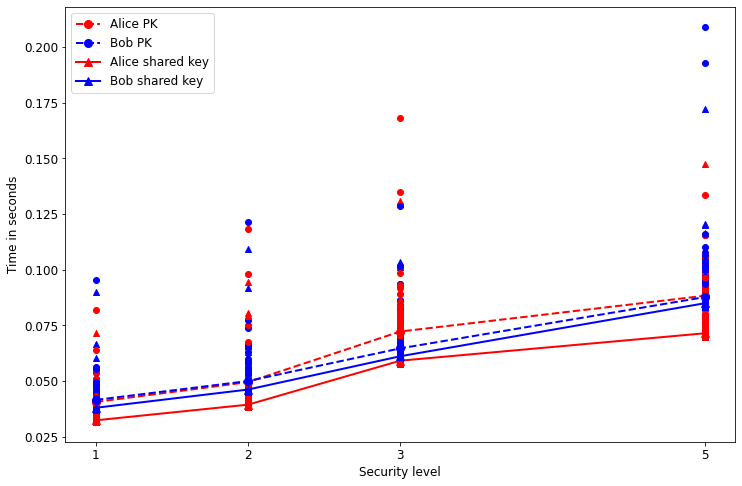

In [34]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
df=pd.DataFrame({'x_values': [1,2,3,5], 'Alice PK': Alice_time_pk3, 'Bob PK': Bob_time_pk3, 'Alice shared key': Alice_time_shared_key3,'Bob shared key': Bob_time_shared_key3 })
factor = 2
# multiple line plots
plt.plot( 'x_values', "Alice PK", data=df, marker='o', markerfacecolor='red', markersize=factor*4, color='red', linewidth=factor, linestyle='dashed')
plt.plot( 'x_values', "Bob PK", data=df, marker='o', markerfacecolor='blue', markersize=factor*4, color='blue', linewidth=factor,linestyle='dashed')
plt.plot( 'x_values', "Alice shared key", data=df, marker='^', markerfacecolor='red', markersize=factor*4, color='red', linewidth=factor)
plt.plot( 'x_values', "Bob shared key", data=df, marker='^', markerfacecolor='blue', markersize=factor*4, color='blue', linewidth=factor)
plt.xticks([1,2,3,5])
ax = plt.subplot()
for index in range (0,iteration,1):
    ax.scatter([1,2,3,5],Alice_time_pk3_multiple[index][0].tolist(),color='red',marker='o')
    ax.scatter([1,2,3,5],Bob_time_pk3_multiple[index][0].tolist(),color='blue',marker='o')
    ax.scatter([1,2,3,5],Alice_time_shared_key3_multiple[index][0].tolist(),color='red',marker='^')
    ax.scatter([1,2,3,5],Bob_time_shared_key3_multiple[index][0].tolist(),color='blue',marker='^')
fontsize = factor*6
ax.set_xlabel('Security level',fontsize=fontsize)
ax.set_ylabel('Time in seconds',fontsize=fontsize)
ax.set_xticklabels([1,2,3,5], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# show legend. 
plt.legend(fontsize=fontsize)
#plt.annotate (Alice_time_pk1[0], (1,Alice_time_pk1[0]))
figure_size = plt.gcf().get_size_inches()
# show graph
plt.gcf().set_size_inches(factor * figure_size)
plt.show()

## This part measures the cpu cycles

In [35]:
#del eA, eB, p, PA, QA,RA, PB, QB,RB, K, I 
## Public Parameters: 
eA_list = [ 216, 250, 305, 372]
eB_list = [137, 159, 192,239]
prime = [434, 503, 610,751]
###----------------------------------------------------------------------------
for index in range(0,iteration,1):
    Alice_cpu_pk3 = [0,0,0,0]
    Bob_cpu_pk3 = [0,0,0,0]
    Alice_cpu_shared_key3 = [0,0,0,0]
    Bob_cpu_shared_key3 = [0,0,0,0]
    for level in range(0,4,1):
        eA = eA_list[level]
        eB = eB_list[level]
        p = mpz(2^eA*3^eB - 1)

        ## The Elliptic Curve (The initial elliptic curve)
        a = initit_fp2(6+0*i)
        b = initit_fp2(1+0*i)

        ## Points on the Elliptic curve
        PA, QA, RA, PB, QB, RB = get_basis_points(level)
        PA = initit_point_projcted(PA)
        QA = initit_point_projcted(QA)
        RA = initit_point_projcted(RA)
        PB = initit_point_projcted(PB)
        QB = initit_point_projcted(QB)
        RB = initit_point_projcted(RB)
        Alicepoints = [PA, QA, RA]
        Bobpoints = [PB, QB, RB]
        strategy4, strategy3 = get_strategy(level)

        ############################# Public keys part ###########################

        ## Public key of Alice
        ##------------------------------------------------------------
        rs = gm.random_state(hash(gm.random_state()))
        sk2 = gm.mpz_random(rs, mpz(2^eA))
        with Timer() as alice_pk_timer:
            pk2 = isogen2(sk2)
        elapsed = alice_pk_timer.cycles
        print("Elapsed cpu cycles to generate Alice pk: ", elapsed)
        Alice_cpu_pk3[level]+= elapsed

        ## Public key of Bob
        ##------------------------------------------------------------
        rs = gm.random_state(hash(gm.random_state()))
        pow1 =mpz(gm.floor(gm.log2(pow(gm.mpz(3),eB))))
        sk3 = gm.mpz_random(rs, mpz(2^pow1))
        with Timer() as bob_pk_timer:
            pk3 = isogen3(sk3)
        elapsed = bob_pk_timer.cycles
        print("Elapsed cpu cycles to generate Bob pk: ", elapsed)
        Bob_cpu_pk3[level]+=elapsed


        ###############################  Shared key part #############################
        ## Alice Shaerd key
        ##-------------------------------------------------------------------------
        with Timer() as alice_sk_timer:
            Alice_shared_key = isox2(sk2,pk3)
        elapsed = alice_sk_timer.cycles
        print("Elapsed time to get the shared key of Alice is: ", elapsed)
        Alice_cpu_shared_key3[level]+=elapsed


        ##Bob Shared key
        ##---------------------------------------------------------------------------
        #print(sk3)
        with Timer() as bob_sk_timer:
            Bob_shared_key = isox3(sk3,pk2)
        elapsed = bob_sk_timer.cycles
        print("Elapsed time to get the shared key of Bob is: ", elapsed)
        Bob_cpu_shared_key3[level]+=elapsed


        ##print the shared key##
        if (Alice_shared_key == Bob_shared_key):
            print("The shared key is: ")
            print(int(Alice_shared_key[0])+int(Alice_shared_key[1])*i)

        else:
            print("some error happened in calculations ...shared keys aren't equals !!! :(")

        print("---------------------------------------------------------------------------")

        Alicetimepk3 = str(Alice_time_pk3)
        file = open('time_measurement_multiple.txt','a')
        file.write(Alicetimepk3+'\n')
        #-------------------------------------------
        Bobtimepk3 = str(Bob_time_pk3)
        file.write(Bobtimepk3+'\n')
        #--------------------------------------------
        Alicetimesharedkey3= str(Alice_time_shared_key3)
        file.write(Alicetimesharedkey3+'\n')
        #----------------------------------------------
        Bobtimesharedkey3 = str(Bob_time_shared_key3)
        file.write(Bobtimesharedkey3+'\n')
        file.close()

        del eA, eB, p, PA, QA,RA, PB, QB,RB
    print('Iteration {} executed successfuly !!\n \n'.format(index))
    if(index == 0):
        Alice_cpu_pk3_multiple = np.array([[Alice_cpu_pk3]])
        Bob_cpu_pk3_multiple = np.array([[Bob_cpu_pk3]])
        Alice_cpu_shared_key3_multiple = np.array([[Alice_cpu_shared_key3]])
        Bob_cpu_shared_key3_multiple = np.array([[Bob_cpu_shared_key3]])
    else:
        row = np.array([Alice_cpu_pk3])
        Alice_cpu_pk3_multiple = np.r_[Alice_cpu_pk3_multiple,[row]]
        
        row = np.array([Bob_cpu_pk3])
        Bob_cpu_pk3_multiple = np.r_[Bob_cpu_pk3_multiple,[row]]
        
        row = np.array([Alice_cpu_shared_key3])
        Alice_cpu_shared_key3_multiple = np.r_[Alice_cpu_shared_key3_multiple,[row]]
        
        row = np.array([Bob_cpu_shared_key3])
        Bob_cpu_shared_key3_multiple = np.r_[Bob_cpu_shared_key3_multiple,[row]]
    



Elapsed cpu cycles to generate Alice pk:  142948332
Elapsed cpu cycles to generate Bob pk:  143397169
Elapsed time to get the shared key of Alice is:  119440941
Elapsed time to get the shared key of Bob is:  130579945
The shared key is: 
589420529306514104190862539956929553790406164563916545367901201402761623099311719902160711015652923279089461557069547082518441238*I + 1488957531060409067754098241309168681078694184328481534541828050265034598945477630223897106658104765259407677887054956348476279108
---------------------------------------------------------------------------
Elapsed cpu cycles to generate Alice pk:  171780378
Elapsed cpu cycles to generate Bob pk:  174235468
Elapsed time to get the shared key of Alice is:  136746465
Elapsed time to get the shared key of Bob is:  159476940
The shared key is: 
6454851845768413074704493269171193028566829935145532335782591182590317171329000455314173265349870378550372733661879486482612610153483530094544180068222*I + 555932113355991674239255828

In [36]:
Alice_cpu_pk3 = (sum(Alice_cpu_pk3_multiple,0)[0]/iteration).tolist()
Alice_cpu_pk3 = [ int(x) for x in Alice_cpu_pk3 ]

In [37]:
Bob_cpu_pk3 = (sum(Bob_cpu_pk3_multiple,0)[0]/iteration).tolist()
Bob_cpu_pk3 = [ int(x) for x in Bob_cpu_pk3]

In [38]:
Alice_cpu_shared_key3 = (sum(Alice_cpu_shared_key3_multiple,0)[0]/iteration).tolist()
Alice_cpu_shared_key3 = [int(x) for x in Alice_cpu_shared_key3]

In [39]:
Bob_cpu_shared_key3= (sum(Bob_cpu_shared_key3_multiple,0)[0]/iteration).tolist()
Bob_cpu_shared_key3 = [int(x) for x in Bob_cpu_shared_key3]

In [40]:
from IPython.display import Markdown as md
md("## Average  CPU cycles to generate the primitives over {} iterations: \n \n <table style='width:80%; border: 1px solid black'><tr><th>  </th><th> Alice's PK</th><th>Bob's PK</th><th>Alice's shared key(sk)</th><th>Bob's shared key (sk)</th></tr><tr><th>p434-level 1</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p503-level 2</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p610-level 3</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><th>p710-level 5</th><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr></table>".format(iteration,Alice_cpu_pk3[0],Bob_cpu_pk3[0],Alice_cpu_shared_key3[0],Bob_cpu_shared_key3[0],Alice_cpu_pk3[1],Bob_cpu_pk3[1],Alice_cpu_shared_key3[1],Bob_cpu_shared_key3[1],Alice_cpu_pk3[2],Bob_cpu_pk3[2],Alice_cpu_shared_key3[2],Bob_cpu_shared_key3[2],Alice_cpu_pk3[3],Bob_cpu_pk3[3],Alice_cpu_shared_key3[3],Bob_cpu_shared_key3[3]))

## Average  CPU cycles to generate the primitives over 1000 iterations: 
 
 <table style='width:80%; border: 1px solid black'><tr><th>  </th><th> Alice's PK</th><th>Bob's PK</th><th>Alice's shared key(sk)</th><th>Bob's shared key (sk)</th></tr><tr><th>p434-level 1</th><td>140426478</td><td>143801767</td><td>112000388</td><td>131457717</td></tr><tr><th>p503-level 2</th><td>170194175</td><td>172613011</td><td>136129070</td><td>159439591</td></tr><tr><th>p610-level 3</th><td>249048196</td><td>223080768</td><td>204068371</td><td>211402900</td></tr><tr><th>p710-level 5</th><td>305525430</td><td>303015796</td><td>247067915</td><td>294032347</td></tr></table>

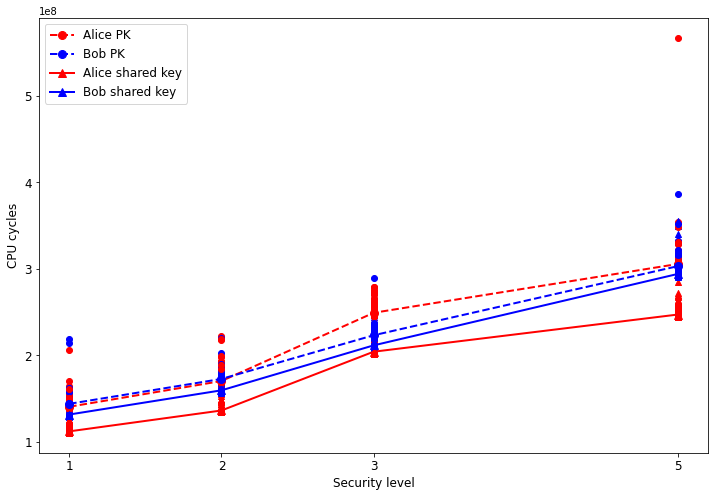

In [41]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
df=pd.DataFrame({'x_values': [1,2,3,5], 'Alice PK': Alice_cpu_pk3, 'Bob PK': Bob_cpu_pk3, 'Alice shared key': Alice_cpu_shared_key3,'Bob shared key': Bob_cpu_shared_key3 })
factor = 2
# multiple line plots
plt.plot( 'x_values', "Alice PK", data=df, marker='o', markerfacecolor='red', markersize=factor*4, color='red', linewidth=factor, linestyle='dashed')
plt.plot( 'x_values', "Bob PK", data=df, marker='o', markerfacecolor='blue', markersize=factor*4, color='blue', linewidth=factor, linestyle='dashed')
plt.plot( 'x_values', "Alice shared key", data=df, marker='^', markerfacecolor='red', markersize=factor*4, color='red', linewidth=factor)
plt.plot( 'x_values', "Bob shared key", data=df, marker='^', markerfacecolor='blue', markersize=factor*4, color='blue', linewidth=factor)
plt.xticks([1,2,3,5])
ax = plt.subplot()
for index in range (0,iteration,1):
    ax.scatter([1,2,3,5],Alice_cpu_pk3_multiple[index][0].tolist(),color='red',marker='o')
    ax.scatter([1,2,3,5],Bob_cpu_pk3_multiple[index][0].tolist(),color='blue',marker='o')
    ax.scatter([1,2,3,5],Alice_cpu_shared_key3_multiple[index][0].tolist(),color='red',marker='^')
    ax.scatter([1,2,3,5],Bob_cpu_shared_key3_multiple[index][0].tolist(),color='blue',marker='^')
fontsize = factor*6
ax.set_xlabel('Security level',fontsize=fontsize)
ax.set_ylabel('CPU cycles',fontsize=fontsize)
ax.set_xticklabels([1,2,3,5], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# show legend. 
plt.legend(fontsize=fontsize)
#plt.annotate (Alice_time_pk1[0], (1,Alice_time_pk1[0]))
figure_size = plt.gcf().get_size_inches()
# show graph
plt.gcf().set_size_inches(factor * figure_size)
plt.show()

# Saving the measurments

## Saving time measurrements

In [42]:
for index in range(0, iteration):
    Alicetimepk3 = str(Alice_time_pk3_multiple[index][0].tolist())
    file = open('time_measurement.txt','a')
    file.write(Alicetimepk3+'\n')
    #-------------------------------------------
    Bobtimepk3 = str(Bob_time_pk3_multiple[index][0].tolist())
    file.write(Bobtimepk3+'\n')
    #--------------------------------------------
    Alicetimesharedkey3 = str(Alice_time_shared_key3_multiple[index][0].tolist())
    file.write(Alicetimesharedkey3+'\n')
    #-------------------------------------------
    Bobtimesharedkey3 = str(Bob_time_shared_key3_multiple[index][0].tolist())
    file.write(Bobtimesharedkey3+'\n')
    #-------------------------------------------
    file.close()

## Saving cpu measurements

In [43]:
for index in range(0, iteration):
    Alicecpupk3 = str(Alice_cpu_pk3_multiple[index][0].tolist())
    file = open('cpu_measurement.txt','a')
    file.write(Alicecpupk3+'\n')
    #-------------------------------------------
    Bobcpupk3 = str(Bob_cpu_pk3_multiple[index][0].tolist())
    file.write(Bobcpupk3+'\n')
    #--------------------------------------------
    Alicecpusharedkey3 = str(Alice_cpu_shared_key3_multiple[index][0].tolist())
    file.write(Alicecpusharedkey3+'\n')
    #-------------------------------------------
    Bobcpusharedkey3 = str(Bob_cpu_shared_key3_multiple[index][0].tolist())
    file.write(Bobcpusharedkey3+'\n')
    #-------------------------------------------
    file.close()

# Save all the measurments combined (# The file will have number of rows equals the number of iterations X 2(# iteration rows for Alice and # iteration rows for Bob)

In [46]:
for index in range(0, iteration):
    Alicetimepk3_combined_multiple = str(np.add(Alice_time_pk3_multiple[index][0],Alice_time_shared_key3_multiple[index][0]).tolist())
    file = open('time_measurement_combined_multiple.txt','a')
    file.write(Alicetimepk3_combined_multiple+'\n')
    #-------------------------------------------
    Bobtimepk3_combined_multiple =  str(np.add(Bob_time_pk3_multiple[index][0],Bob_time_shared_key3_multiple[index][0]).tolist())
    file.write(Bobtimepk3_combined_multiple+'\n')
    #--------------------------------------------
    file.close()

In [47]:
for index in range(0, iteration):
    Alicecpupk3_combined_multiple = str(np.add(Alice_cpu_pk3_multiple[index][0],Alice_cpu_shared_key3_multiple[index][0]).tolist())
    file = open('cpu_measurement_combined_multiple.txt','a')
    file.write(Alicecpupk3_combined_multiple+'\n')
    #-------------------------------------------
    Bobcpupk3_combined_multiple =  str(np.add(Bob_cpu_pk3_multiple[index][0],Bob_cpu_shared_key3_multiple[index][0]).tolist())
    file.write(Bobcpupk3_combined_multiple+'\n')
    #--------------------------------------------
    file.close()